### Imports

In [5]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import agent
# from q_learning_agent import QLearningAgent
from gridworld_with_door import MazeEnvironment
from tqdm import tqdm
from priority_sampling.nn_agent import LinearAgent as NNAgent
from priority_sampling.nn_agent_sample import LinearAgent as NNAgentP
from priority_sampling.rnn_agent_sample import RNNAgent as RNNAgentP
from priority_sampling.rnn_agent import RNNAgent as RNNAgent
from priority_sampling.rnn_agent_trace import RNNAgent as TraceAgent
from priority_sampling.rnn_agent_trace_sample import RNNAgent as TraceSampleAgent
from sarsa_agent import SarsaAgent
from q_learning_agent import QLearningAgent
from IPython.display import HTML, Image
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import animation
# enable if ffmpeg codec is installed 
# plt.rcParams['animation.ffmpeg_path'] = '/anaconda3/envs/pytorch/bin/ffmpeg'

In [6]:
plt.rcParams.update({'font.size': 15})
plt.rcParams.update({'figure.figsize': [10,5]})

### Helpers

In [7]:
def run_episode(env, agent, state_visits=None, keep_history=False):
    is_terminal = False
    sum_of_rewards = 0
    step_count = 0
    
    obs = env.env_start(keep_history=keep_history)
    action = agent.agent_start(obs)
    
    if state_visits is not None:
        state_visits[obs[0]] += 1

    while not is_terminal:
        reward, obs, is_terminal = env.env_step(action)
        print(agent.steps,end='\r')
#         sum_of_rewards += reward
        sum_of_rewards -= 1
        step_count += 1
        state = obs
        if step_count == 500:
            agent.agent_end(reward, state, append_buffer=False)
#             action = agent.agent_step(reward, state)
#             if hasattr(agent, 'buffer'):
#                 agent.buffer.clear()
            break
        elif is_terminal:
            agent.agent_end(reward, state, append_buffer=True)
#             agent.agent_end(reward)
        else:
            action = agent.agent_step(reward, state)

        if state_visits is not None:
            state_visits[state[0]] += 1
    
    if keep_history:
        history = env.history
        env.env_cleanup()
        return sum_of_rewards, history
    else:
        return sum_of_rewards

In [8]:
def animate(history, name='history.gif'):
    frames = len(history)
    print(f"Rendering {frames} frames...")
    fig = plt.figure(figsize=(6, 2))
    fig_grid = fig.add_subplot(121)

    def render_frame(i):
        grid = history[i]
        fig_grid.matshow(grid, vmin=-1, vmax=1, cmap='jet')
    anim = animation.FuncAnimation(fig, render_frame, frames=frames, interval=100);
    plt.close(anim._fig)
    # Option a) if ffmpeg codec is installed, display animation with ffmpeg
    # display(HTML(anim.to_html5_video()))
    # Option b) save as gif and display
    anim.save(name, dpi=80, writer=animation.PillowWriter(fps=20));
    with open(name,'rb') as file:
        display(Image(file.read()))

### Experiment Setup

In [9]:
def reload(obj):
   import inspect
   import imp
   cur_mod = inspect.getmodule(obj)
   imp.reload(cur_mod)
   mod_name = cur_mod.__name__
   obj_name = obj.__name__
   #from mod_name import obj_name as obj
   return getattr(__import__(mod_name, fromlist=[obj_name]), obj_name)

In [11]:
# importlib.reload(inspect.getmodule(SumTree))
# importlib.reload(inspect.getmodule(Memory))


In [75]:
QLearningAgent = reload(QLearningAgent)
# SarsaAgent = reload(SarsaAgent)
RNNAgent = reload(RNNAgent)
# NNAgent = reload(NNAgent)
# NNAgentP = reload(NNAgentP)
TraceAgent = reload(TraceAgent)
RNNAgentP = reload(RNNAgentP)
TraceSampleAgent = reload(TraceSampleAgent)

agents = {
#     "Q-learning": QLearningAgent,
#     "Linear": LinearAgent,
#     "Sarsa": QLearningAgent,
#     "NN": NNAgent,
#     "NNP": NNAgentP,
#     "RNN": RNNAgent,
#     "RNN_MSE": RNNAgent,
#     "RNN_Multi": RNNAgent,
#     "RNN_Multi_MSE": RNNAgent,
    "RNNP": RNNAgentP,
#     "RNNP_MSE": RNNAgentP,
#     "Trace": TraceAgent,
#     "Trace_MSE": TraceAgent,
    "TraceSample": TraceSampleAgent
}

In [63]:
# temp_rnnp, temp_rnnp_mse = all_reward_sums['RNNP'], all_reward_sums['RNNP_MSE']
# all_reward_sums['RNNP'], all_reward_sums['RNNP_MSE'] = [], []

In [64]:
import inspect
inspect.getmodule(RNNAgentP()).criterion

SmoothL1Loss()

In [65]:
import inspect
inspect.getmodule(TraceSampleAgent()).criterion

SmoothL1Loss()

In [66]:
envs = {
    'Grid-World': MazeEnvironment,
}
agent_infos = {
    "Q-learning": {"step_size": .5},
    "Sarsa": {"step_size": 1e-2, 'num_tilings': 4, 'num_tiles': 4, 'iht_size': 300},
    "Linear": {"step_size": 1e-3},
    "NN": {"step_size": 1e-3},
    "RNN": {"step_size": 1e-3},
    "RNN_MSE": {"step_size": 1e-3},
    "RNN_Multi": {"step_size": 1e-3},
    "RNN_Multi_MSE": {"step_size": 1e-3},
    "NNP": {"step_size": 1e-3},
    "RNNP": {"step_size": 1e-3},
    "RNNP_MSE": {"step_size": 1e-3},
    "Trace": {"step_size": 1e-3},
    "Trace_MSE": {"step_size": 1e-3},
    "TraceSample": {"step_size": 1e-3},
}
env_info = {
    "maze_dim": [7, 7], 
    "start_state": [0, 6], 
    "end_state": [6, 6],
    "obstacles": [[3, 3], [3, 4], [3, 5], [3, 6], [4, 3], [5, 3], [6, 3]],
#     "obstacles":[],
#     "obstacles": [[3, 3], [3, 5], [3, 6], [4, 3], [5, 3], [6, 3]],
#     "doors": {tuple([6,0]):[3,4]},
    "doors": {tuple([6,0]):[[3, 3], [3, 4], [3, 5], [3, 6]]},
#     "doors": {tuple([2,4]):[3,4]},
}

### Train

In [67]:
# all_reward_sums = {} # Contains sum of rewards during episode
# all_state_visits = {} # Contains state visit counts during the last 10 episodes
# all_history = {}

In [68]:
# all_reward_sums['RNN'] = []
# all_reward_sums_sarsa_tile_4 = all_reward_sums['Sarsa']
# all_reward_sums['Sarsa'] = []

In [69]:
# agent.buffer.tree.total()

In [70]:
num_runs = 1
num_episodes = 500
Environment = envs['Grid-World']

for algorithm in tqdm(list(agents.keys())):
    all_reward_sums[algorithm] = []
    all_state_visits[algorithm] = []
    
    for run in tqdm(range(num_runs)):
        agent = agents[algorithm]()
        env = Environment()
        
        env.env_init(env_info)
        agent_info = {"num_actions": 4, "num_states": env.cols * env.rows, "epsilon": .1, "step_size": 0.5, "discount": .9} 
        agent_info["seed"] = run
        agent_info.update(agent_infos[algorithm])
        np.random.seed(run)
        agent.agent_init(agent_info)
        
        reward_sums = []
        state_visits = np.zeros(env.cols * env.rows)
        epsilon = 1
        for episode in range(num_episodes):
            print(f"episode {episode}",end='\r')
#             print("")
            agent.epsilon = epsilon
            if episode < num_episodes - 10:
                sum_of_rewards = run_episode(env, agent) 
            else: 
                # Runs an episode while keeping track of visited states and history
                sum_of_rewards, history = run_episode(env, agent, state_visits, keep_history=True)
                all_history.setdefault(algorithm, []).append(history)
            epsilon *= 0.99
            reward_sums.append(sum_of_rewards)
        all_reward_sums[algorithm].append(reward_sums)
        all_state_visits[algorithm].append(state_visits)

  0%|          | 0/1 [00:00<?, ?it/s]


100%|██████████| 1/1 [24:05<00:00, 1445.81s/it]

In [55]:
agent.rnn.actions

AttributeError: 'LinearAgent' object has no attribute 'rnn'

In [172]:
agent.epsilon

0.1

In [48]:
agent.train_steps

500

In [49]:
episode

199

In [50]:
len(agent.buffer)

1000

In [51]:
agent.hidden

tensor([[ 0.0348, -0.0270,  0.0694,  0.1271,  0.0806, -0.0857,  0.1075,  0.1537,
          0.1444,  0.1532,  0.1709,  0.0333,  0.0304,  0.0530,  0.0853,  0.0314,
         -0.0238,  0.0804, -0.1845, -0.0182,  0.2372, -0.0248,  0.0449, -0.0173,
          0.1451, -0.2200, -0.1881,  0.1172, -0.0535,  0.0267,  0.1051, -0.0246,
         -0.0380,  0.0573, -0.0334, -0.1131, -0.1532,  0.2871,  0.0348,  0.1919,
          0.0250,  0.0521, -0.0085, -0.0041, -0.0998, -0.0214, -0.0488, -0.0629,
         -0.0942,  0.0443]], device='cuda:0')

### Evaluate Results

In [544]:
from torch.nn import functional as F

In [551]:
np.round(F.softmax(agent.rnn.lambdas).detach().cpu().numpy(),3)

/home/derek/anaconda3/envs/fpp/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  """Entry point for launching an IPython kernel.


array([0.44 , 0.292, 0.147, 0.062, 0.03 , 0.017, 0.008, 0.003, 0.001,
       0.   ], dtype=float32)

In [16]:
len(agent.buffer)

1000

In [179]:
agent.steps

22

In [182]:
np.max(all_reward_sums['RNN'])

-16

In [48]:
all_reward_sums['Sarsa'][-1][-1]

-14

In [258]:
import inspect
inspect.getmodule(agent).criterion

In [265]:
len(all_reward_sums['Trace'])

6

In [266]:
all_reward_sums['Trace_MSE'] = []

In [532]:
np.mean(all_reward_sums['Trace'][0][100:]), np.mean(all_reward_sums['Trace_MSE'][0][100:])

(-34.675, -34.305)

(-93.428, -99.2816)

In [533]:
np.mean(all_reward_sums['RNN']), np.mean(all_reward_sums['RNN_MSE']), np.mean(all_reward_sums['RNNP']), np.mean(all_reward_sums['RNNP_MSE']), \
np.mean(all_reward_sums['Trace']), np.mean(all_reward_sums['Trace_MSE'])

(-127.6715, -142.2005, -80.4552, -82.7456)

In [537]:
np.mean(np.array(all_reward_sums['RNN'])[:,300:]), np.mean(np.array(all_reward_sums['RNN_MSE'])[:,300:]), np.mean(np.array(all_reward_sums['RNNP'])[:,300:]), \
np.mean(np.array(all_reward_sums['RNNP_MSE'])[:,300:]), np.mean(np.array(all_reward_sums['Trace'])[:,300:]), np.mean(np.array(all_reward_sums['Trace_MSE'])[:,300:])

(-31.46625, -29.96375, -29.87, -29.844, -29.025833333333335, -28.252)

In [73]:
np.mean(all_reward_sums['TraceSample'][0][300:]), np.mean(all_reward_sums['RNNP'][0][300:])

(-26.88, -27.18)

In [33]:
for i, algorithm in enumerate(list(agents.keys())):
    print(algorithm, np.mean(all_reward_sums[algorithm]))

Sarsa -29.634
NN -26.844
NN_P -28.154


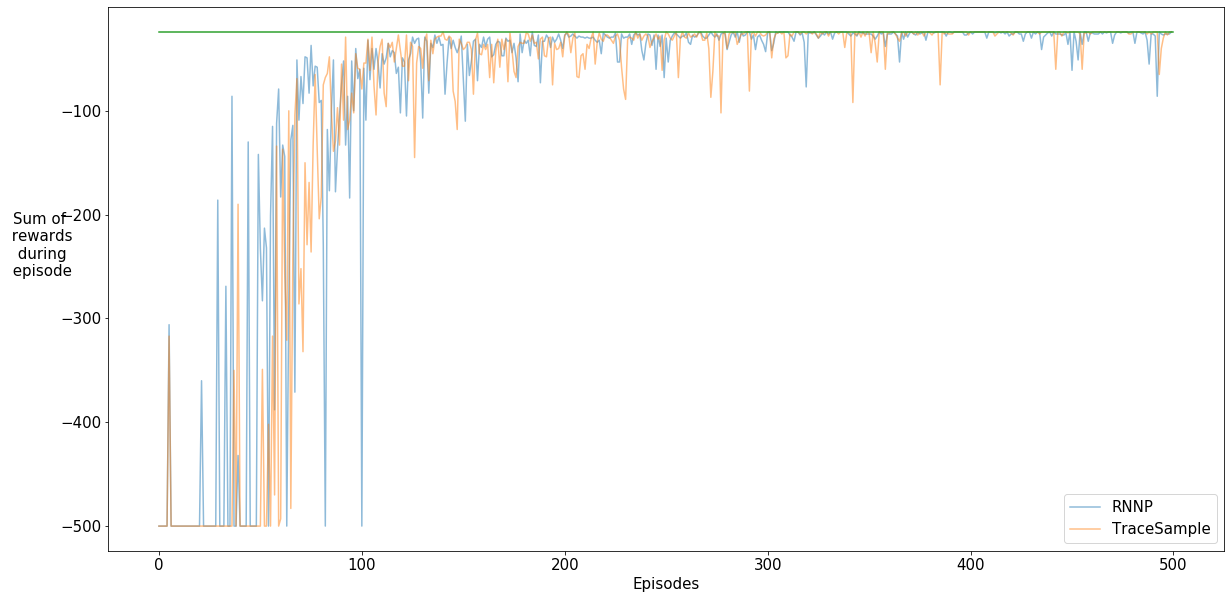

In [77]:
plt.figure(figsize=(20,10))
for i, algorithm in enumerate(list(agents.keys())):
    algorithm_means = np.mean(all_reward_sums[algorithm], axis=0)
    algorithm_stds = np.std(all_reward_sums[algorithm], axis=0)
    plt.plot(algorithm_means, label=algorithm, alpha=0.5)
    plt.fill_between(range(num_episodes), algorithm_means + algorithm_stds/np.sqrt(num_runs), algorithm_means - algorithm_stds/np.sqrt(num_runs), alpha=0.2)
plt.ylabel("Sum of\n rewards\n during\n episode",rotation=0, labelpad=20)
plt.xlabel("Episodes")
# plt.ylim(-100, -10)
plt.plot([0,500],[-24,-24])

plt.legend()
plt.show()


/home/derek/anaconda3/envs/fpp/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/derek/anaconda3/envs/fpp/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/derek/anaconda3/envs/fpp/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/derek/anaconda3/envs/fpp/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/derek/anaconda3/envs/fpp/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


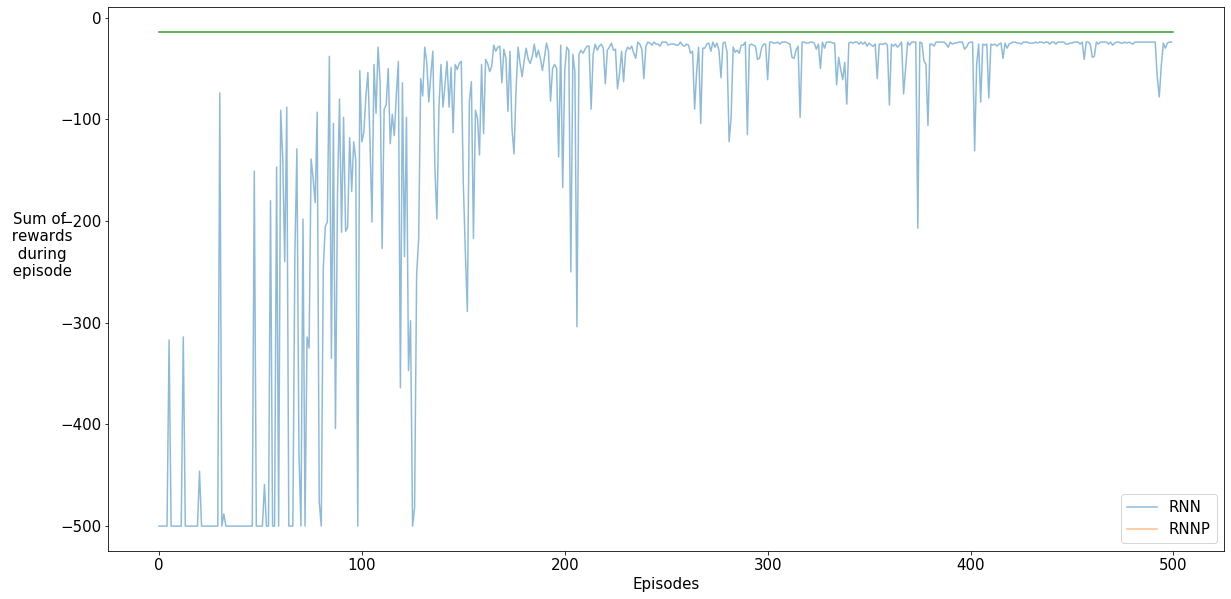

In [150]:
plt.figure(figsize=(20,10))
for i, algorithm in enumerate(list(agents.keys())):
    algorithm_means = np.mean(all_reward_sums[algorithm], axis=0)
    algorithm_stds = np.std(all_reward_sums[algorithm], axis=0)
    plt.plot(algorithm_means, label=algorithm, alpha=0.5)
    plt.fill_between(range(num_episodes), algorithm_means + algorithm_stds/np.sqrt(num_runs), algorithm_means - algorithm_stds/np.sqrt(num_runs), alpha=0.2)
plt.ylabel("Sum of\n rewards\n during\n episode",rotation=0, labelpad=20)
plt.xlabel("Episodes")
# plt.ylim(-100, -10)
plt.plot([0,500],[-14,-14])

plt.legend()
plt.show()


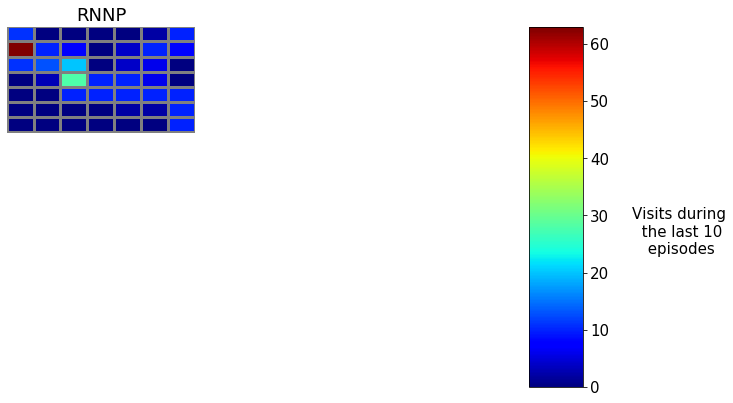

In [162]:
for i, algorithm in enumerate(list(agents.keys())): 
    position = int(f"32{i+1}")
    plt.subplot(position)
    average_state_visits = np.array(all_state_visits[algorithm]).mean(axis=0)
    grid_state_visits = average_state_visits.reshape((env.rows,env.cols))
    plt.pcolormesh(grid_state_visits, edgecolors='gray', linewidth=2, cmap='jet')
    plt.title(algorithm)
    plt.axis('off')
    cm = plt.get_cmap()
    cm.set_bad('gray')

    plt.subplots_adjust(bottom=0.0, right=0.7, top=1.0)
    cax = plt.axes([0.85, 0.0, 0.075, 1.])
cbar = plt.colorbar(cax=cax)
cbar.ax.set_ylabel("Visits during\n the last 10\n episodes", rotation=0, labelpad=70)
plt.show()

Rendering 15 frames...


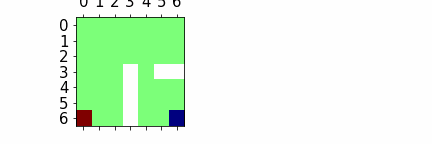

In [56]:
animate(all_history['RNN'][-8][-100:], name='history_RNN.gif')

Rendering 25 frames...


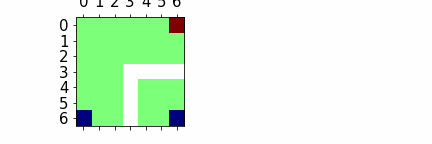

In [163]:
animate(all_history['RNNP'][-1], name='history_Linear.gif')

Rendering 26 frames...


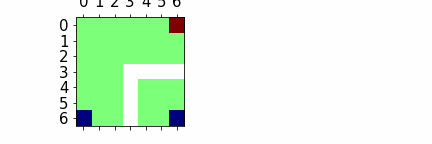

In [80]:
animate(all_history['NN_P'][-1], name='history_NNP.gif')

In [81]:
[len(x) for x in all_history['Sarsa'][-10:]]

[501, 24, 39, 27, 31, 77, 64, 34, 25, 21]

In [82]:
agent.nn.weight.shape

AttributeError: 'SarsaAgent' object has no attribute 'nn'

In [11]:
import torch

In [12]:
def mask_grid(grid, blocks, mask_value=-100):
   for i in range(grid.shape[0]):
       for j in range(grid.shape[1]):
           if [i,j] in blocks:
               grid[i,j] = mask_value
   grid = np.ma.masked_where(grid == mask_value, grid)
   return grid

In [14]:
# hidden = agent.rnn.initHidden()

In [15]:
agent.get_state_feature(env.get_state_features([0,6]))

tensor([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')

In [16]:
# def get_action_values_matrix(state):
#     state = agent.get_state_feature(env.get_state_features(state))
#     with torch.no_grad():
#         current_q, _ = agent.rnn(state, hidden)
#     current_q.squeeze_()
#     temp = np.zeros((3,3))
#     temp[0,1] = current_q[0]
#     temp[1,2] = current_q[1]
#     temp[2,1] = current_q[2]
#     temp[1,0] = current_q[3]
# #     temp[1,1] = current_q[4]
#     return temp

def get_action_values_matrix(state):
    state = agent.get_state_feature(env.get_state_features(state))
    with torch.no_grad():
        current_q = agent.nn(state)
    current_q.squeeze_()
    temp = np.zeros((3,3))
    temp[0,1] = current_q[0]
    temp[1,2] = current_q[1]
    temp[2,1] = current_q[2]
    temp[1,0] = current_q[3]
#     temp[1,1] = current_q[4]
    return temp

In [17]:
get_action_values_matrix([0,0])

array([[ 0.        , 17.44148445,  0.        ],
       [17.45305061,  0.        , 17.6096611 ],
       [ 0.        , 17.41506004,  0.        ]])

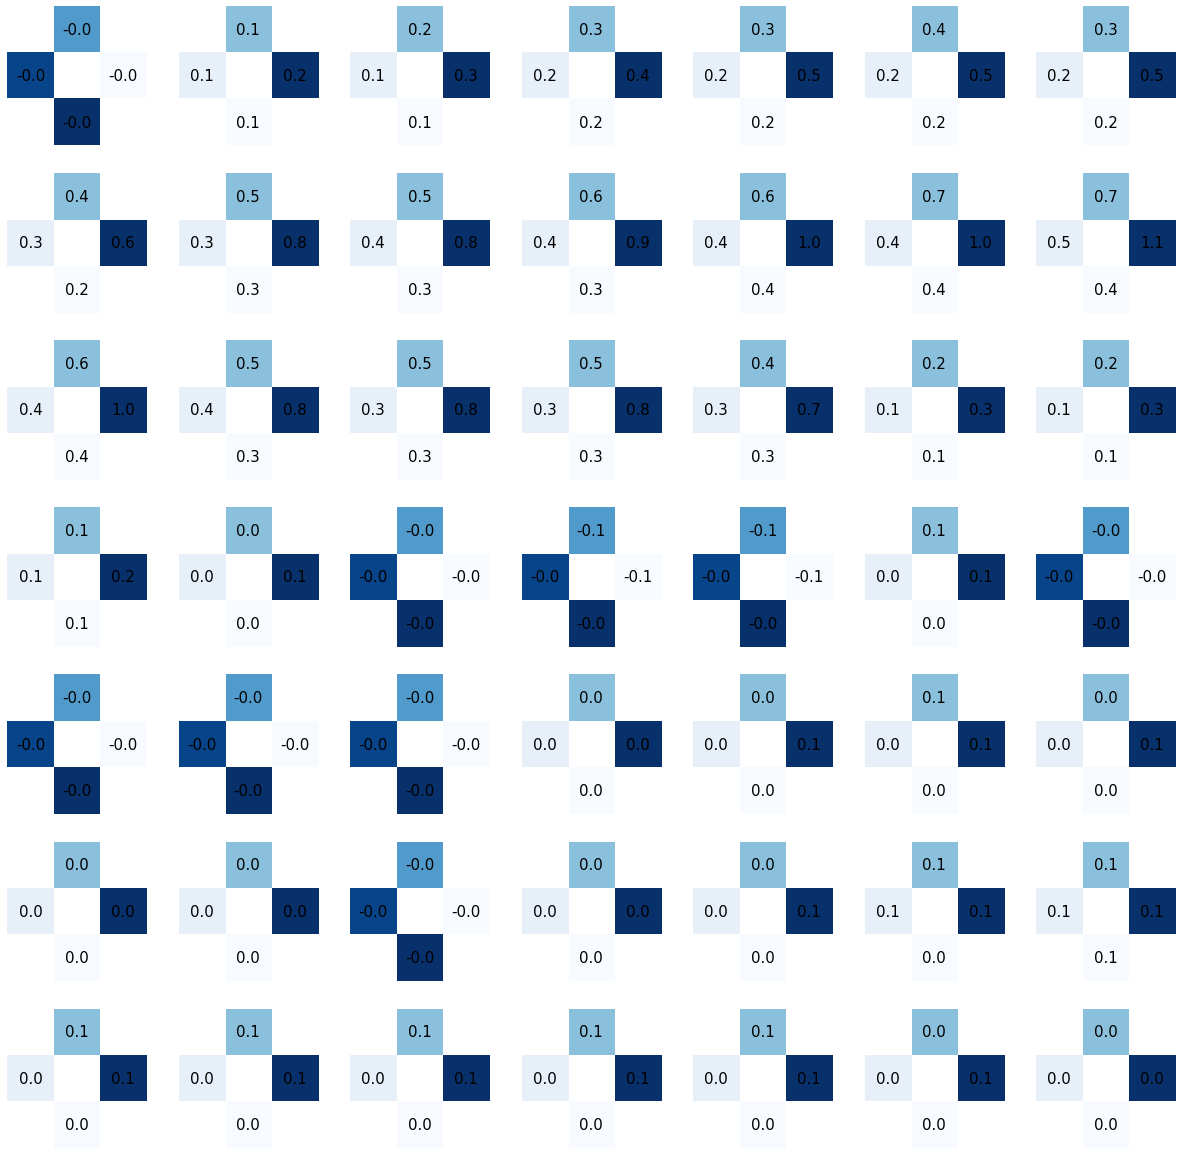

In [33]:
num_row, num_col = env.maze_dim
plt.figure(1, figsize=(num_row*3, num_col*3))
for i,row in enumerate(range(num_row-1,-1,-1)):
    for col in range(num_col):
        if [row,col] not in env.obstacles:
            ax = plt.subplot(num_row, num_col, i*num_col + col + 1)
            state = [row,col]
            #            state_occupancy_map = mask_grid(np.mean(agent.m[:,state,:],axis=0).reshape(7,7),env.obstacles)
            action_values_map = mask_grid(get_action_values_matrix(state), [[0,0],[1,1],[0,2],[2,0],[2,2]])
            plt.axis('off')
#            ax.imshow(action_values_map,origin='lower',cmap='Greys')
            ax.matshow(action_values_map,cmap='Blues')
#             ax.text(i+0.5, j+0.5, str(c), va='center', ha='center')
#             ax.set_ylim(0,6)
            for (x, y), z in np.ndenumerate(action_values_map):
                if [x, y] not in [[0,0],[1,1],[0,2],[2,0],[2,2]]:
                    ax.text(y, x, '{:0.1f}'.format(z), ha='center', va='center')

## Param Search

In [312]:
import pandas as pd
import random

In [315]:
MAX_EVALS=10

In [316]:
from fastprogress.fastprogress import master_bar, progress_bar

In [317]:
# mb = master_bar(range(1))
# for j in mb:
#     for i in progress_bar(range(MAX_EVALS),parent=mb):
#         print(i)

In [318]:
def random_search(param_grid, mb=master_bar(range(1)), max_evals = MAX_EVALS):
    """Random search for hyperparameter optimization"""
    
    # Dataframe for results
    results = pd.DataFrame(columns = ['score', 'params', 'iteration'],
                                  index = list(range(MAX_EVALS)))
    
    # Keep searching until reach max evaluations
    for j in mb:
        for i in progress_bar(range(MAX_EVALS),parent=mb):

            # Choose random hyperparameters
            hyperparameters = {k: random.sample(v, 1)[0] for k, v in param_grid.items()}
            print(hyperparameters)
            # Evaluate randomly selected hyperparameters
            eval_results = objective(hyperparameters, i)

            results.loc[i, :] = eval_results
    
    # Sort with best score on top
    results.sort_values('score', ascending = False, inplace = True)
    results.reset_index(inplace = True)
    return results 

In [319]:
SarsaAgent = reload(SarsaAgent)
agents = {
    "Sarsa": SarsaAgent,
}
agent_infos = {
    "Sarsa": {},
}
param_grid = dict(
    num_tilings=[4,8,16,32],
    num_tiles=[4,8,16,32],
    iht_size=[50, 100, 200, 300, 400, 500],
)

In [320]:

def objective(hyper_params, i):
    all_reward_sums = {} # Contains sum of rewards during episode
    num_runs = 10
    num_episodes = 500
    Environment = envs['Grid-World']

    for algorithm in tqdm(list(agents.keys())):
        all_reward_sums[algorithm] = []
        all_state_visits[algorithm] = []

        for run in tqdm(range(num_runs)):
            agent = agents[algorithm]()
            env = Environment()

            env.env_init(env_info)
            agent_info = {"num_actions": 4, "num_states": env.cols * env.rows, "epsilon": .1, "step_size": 0.5, "discount": 0.9} 
            agent_info["seed"] = run
            agent_info.update(agent_infos[algorithm])
            agent_info.update(hyper_params)
            agent_info['step_size'] = 1e-2 * 4 / agent_info['num_tilings']
            np.random.seed(run)
            agent.agent_init(agent_info)

            reward_sums = []
            state_visits = np.zeros(env.cols * env.rows)
            for episode in range(num_episodes):
#                 print(f"episode {episode}",end='\r')
#                 print("")
                sum_of_rewards = run_episode(env, agent) 

                reward_sums.append(sum_of_rewards)
            all_reward_sums[algorithm].append(reward_sums)
    return np.mean(all_reward_sums[algorithm]), hyper_params, i

In [321]:
df = random_search(param_grid)

  0%|          | 0/10 [00:00<?, ?it/s]

{'num_tilings': 16, 'num_tiles': 8, 'iht_size': 50}
IHT full, starting to allow collisions
404


 10%|█         | 1/10 [00:46<06:54, 46.07s/it]

IHT full, starting to allow collisions



 20%|██        | 2/10 [01:32<06:09, 46.21s/it]

IHT full, starting to allow collisions



 30%|███       | 3/10 [02:01<04:47, 41.00s/it]

IHT full, starting to allow collisions
349


 40%|████      | 4/10 [02:47<04:14, 42.47s/it]

IHT full, starting to allow collisions
669


 50%|█████     | 5/10 [03:33<03:37, 43.56s/it]

IHT full, starting to allow collisions
257


 60%|██████    | 6/10 [04:20<02:58, 44.59s/it]

IHT full, starting to allow collisions
211


 70%|███████   | 7/10 [05:07<02:16, 45.38s/it]

IHT full, starting to allow collisions
391


 80%|████████  | 8/10 [05:56<01:32, 46.40s/it]

IHT full, starting to allow collisions
400


 90%|█████████ | 9/10 [06:42<00:46, 46.29s/it]

IHT full, starting to allow collisions
451


100%|██████████| 1/1 [07:27<00:00, 447.66s/it]


  0%|          | 0/10 [00:00<?, ?it/s]

{'num_tilings': 4, 'num_tiles': 16, 'iht_size': 300}
IHT full, starting to allow collisions
126


 10%|█         | 1/10 [00:18<02:47, 18.66s/it]

IHT full, starting to allow collisions
185


 20%|██        | 2/10 [00:46<02:51, 21.47s/it]

IHT full, starting to allow collisions
038


 30%|███       | 3/10 [01:14<02:44, 23.46s/it]

IHT full, starting to allow collisions



 40%|████      | 4/10 [01:46<02:35, 25.97s/it]

IHT full, starting to allow collisions
496


 50%|█████     | 5/10 [02:17<02:16, 27.33s/it]

IHT full, starting to allow collisions
398


 60%|██████    | 6/10 [02:48<01:54, 28.60s/it]

IHT full, starting to allow collisions
349


 70%|███████   | 7/10 [03:14<01:23, 27.84s/it]

IHT full, starting to allow collisions
523


 80%|████████  | 8/10 [03:36<00:52, 26.01s/it]

IHT full, starting to allow collisions
570


 90%|█████████ | 9/10 [04:05<00:26, 26.78s/it]

IHT full, starting to allow collisions
327


100%|██████████| 1/1 [04:31<00:00, 271.70s/it]


  0%|          | 0/10 [00:00<?, ?it/s]

{'num_tilings': 16, 'num_tiles': 16, 'iht_size': 500}
IHT full, starting to allow collisions
730


 10%|█         | 1/10 [00:25<03:53, 25.90s/it]

IHT full, starting to allow collisions



 20%|██        | 2/10 [00:46<03:14, 24.32s/it]

IHT full, starting to allow collisions
343


 30%|███       | 3/10 [00:57<02:22, 20.40s/it]

IHT full, starting to allow collisions
200


 40%|████      | 4/10 [01:25<02:16, 22.67s/it]

IHT full, starting to allow collisions
276


 50%|█████     | 5/10 [01:50<01:56, 23.23s/it]

IHT full, starting to allow collisions
299


 60%|██████    | 6/10 [02:37<02:01, 30.41s/it]

IHT full, starting to allow collisions



 70%|███████   | 7/10 [03:08<01:32, 30.75s/it]

IHT full, starting to allow collisions
589


 80%|████████  | 8/10 [03:37<01:00, 30.18s/it]

IHT full, starting to allow collisions
497


 90%|█████████ | 9/10 [04:21<00:34, 34.11s/it]

IHT full, starting to allow collisions
428


100%|██████████| 1/1 [05:08<00:00, 308.78s/it]


  0%|          | 0/10 [00:00<?, ?it/s]

{'num_tilings': 8, 'num_tiles': 32, 'iht_size': 100}
IHT full, starting to allow collisions
360


 10%|█         | 1/10 [00:45<06:45, 45.03s/it]

IHT full, starting to allow collisions
454


 20%|██        | 2/10 [01:17<05:30, 41.37s/it]

IHT full, starting to allow collisions
385


 30%|███       | 3/10 [01:53<04:38, 39.76s/it]

IHT full, starting to allow collisions
130


 40%|████      | 4/10 [02:21<03:36, 36.17s/it]

IHT full, starting to allow collisions
319


 50%|█████     | 5/10 [03:08<03:17, 39.51s/it]

IHT full, starting to allow collisions
342


 60%|██████    | 6/10 [03:55<02:46, 41.72s/it]

IHT full, starting to allow collisions
242


 70%|███████   | 7/10 [04:41<02:08, 42.99s/it]

IHT full, starting to allow collisions
292


 80%|████████  | 8/10 [05:29<01:28, 44.26s/it]

IHT full, starting to allow collisions
127


 90%|█████████ | 9/10 [06:11<00:43, 43.60s/it]

IHT full, starting to allow collisions



100%|██████████| 1/1 [06:57<00:00, 417.78s/it]


  0%|          | 0/10 [00:00<?, ?it/s]

{'num_tilings': 16, 'num_tiles': 16, 'iht_size': 400}
IHT full, starting to allow collisions
118


 10%|█         | 1/10 [00:46<06:54, 46.08s/it]

IHT full, starting to allow collisions
302


 20%|██        | 2/10 [01:18<05:36, 42.12s/it]

IHT full, starting to allow collisions
774

 30%|███       | 3/10 [01:30<03:49, 32.83s/it]

IHT full, starting to allow collisions
141


 40%|████      | 4/10 [01:53<03:00, 30.08s/it]

IHT full, starting to allow collisions
116


 50%|█████     | 5/10 [02:20<02:25, 29.04s/it]

IHT full, starting to allow collisions
404


 60%|██████    | 6/10 [03:06<02:16, 34.09s/it]

IHT full, starting to allow collisions
168


 70%|███████   | 7/10 [03:42<01:44, 34.79s/it]

IHT full, starting to allow collisions



 80%|████████  | 8/10 [04:28<01:16, 38.18s/it]

IHT full, starting to allow collisions
385


 90%|█████████ | 9/10 [05:16<00:40, 40.91s/it]

IHT full, starting to allow collisions



100%|██████████| 1/1 [05:38<00:00, 338.11s/it]


  0%|          | 0/10 [00:00<?, ?it/s]

{'num_tilings': 32, 'num_tiles': 32, 'iht_size': 300}
IHT full, starting to allow collisions
899


 10%|█         | 1/10 [00:52<07:51, 52.35s/it]

IHT full, starting to allow collisions
919


 20%|██        | 2/10 [01:41<06:50, 51.29s/it]

IHT full, starting to allow collisions
100


 30%|███       | 3/10 [02:32<05:59, 51.40s/it]

IHT full, starting to allow collisions
470


 40%|████      | 4/10 [03:25<05:10, 51.68s/it]

IHT full, starting to allow collisions
267


 50%|█████     | 5/10 [04:16<04:17, 51.52s/it]

IHT full, starting to allow collisions
434


 60%|██████    | 6/10 [05:08<03:27, 51.87s/it]

IHT full, starting to allow collisions
495

 70%|███████   | 7/10 [06:00<02:35, 51.83s/it]

IHT full, starting to allow collisions



 80%|████████  | 8/10 [06:53<01:44, 52.14s/it]

IHT full, starting to allow collisions



 90%|█████████ | 9/10 [07:45<00:52, 52.04s/it]

IHT full, starting to allow collisions
549


100%|██████████| 1/1 [08:37<00:00, 517.69s/it]


  0%|          | 0/10 [00:00<?, ?it/s]

{'num_tilings': 16, 'num_tiles': 8, 'iht_size': 50}
IHT full, starting to allow collisions
282


 10%|█         | 1/10 [00:48<07:15, 48.42s/it]

IHT full, starting to allow collisions
649


 20%|██        | 2/10 [01:37<06:29, 48.67s/it]

IHT full, starting to allow collisions
388


 30%|███       | 3/10 [02:08<05:02, 43.21s/it]

IHT full, starting to allow collisions
279


 40%|████      | 4/10 [02:56<04:28, 44.73s/it]

IHT full, starting to allow collisions
179


 50%|█████     | 5/10 [03:42<03:45, 45.10s/it]

IHT full, starting to allow collisions
454


 60%|██████    | 6/10 [04:30<03:04, 46.04s/it]

IHT full, starting to allow collisions
400


 70%|███████   | 7/10 [05:19<02:21, 47.03s/it]

IHT full, starting to allow collisions
177


 80%|████████  | 8/10 [06:07<01:34, 47.33s/it]

IHT full, starting to allow collisions
497


 90%|█████████ | 9/10 [06:56<00:47, 47.74s/it]

IHT full, starting to allow collisions
499


100%|██████████| 1/1 [07:45<00:00, 465.23s/it]


  0%|          | 0/10 [00:00<?, ?it/s]

{'num_tilings': 4, 'num_tiles': 32, 'iht_size': 100}
IHT full, starting to allow collisions
327


 10%|█         | 1/10 [00:27<04:11, 27.95s/it]

IHT full, starting to allow collisions
213


 20%|██        | 2/10 [00:55<03:43, 27.90s/it]

IHT full, starting to allow collisions
313


 30%|███       | 3/10 [01:30<03:30, 30.07s/it]

IHT full, starting to allow collisions
495

 40%|████      | 4/10 [02:06<03:10, 31.79s/it]

IHT full, starting to allow collisions
103


 50%|█████     | 5/10 [02:47<02:52, 34.52s/it]

IHT full, starting to allow collisions
170


 60%|██████    | 6/10 [03:17<02:12, 33.21s/it]

IHT full, starting to allow collisions
329


 70%|███████   | 7/10 [03:56<01:44, 34.82s/it]

IHT full, starting to allow collisions
337


 80%|████████  | 8/10 [04:38<01:14, 37.09s/it]

IHT full, starting to allow collisions
466


 90%|█████████ | 9/10 [05:18<00:37, 37.87s/it]

IHT full, starting to allow collisions



100%|██████████| 1/1 [05:58<00:00, 358.97s/it]


  0%|          | 0/10 [00:00<?, ?it/s]

{'num_tilings': 32, 'num_tiles': 4, 'iht_size': 100}
IHT full, starting to allow collisions



 10%|█         | 1/10 [00:32<04:55, 32.80s/it]

IHT full, starting to allow collisions
228


 20%|██        | 2/10 [00:56<03:59, 29.92s/it]

IHT full, starting to allow collisions
418


 30%|███       | 3/10 [01:46<04:13, 36.20s/it]

IHT full, starting to allow collisions



 40%|████      | 4/10 [02:38<04:04, 40.79s/it]

IHT full, starting to allow collisions



 50%|█████     | 5/10 [03:18<03:23, 40.71s/it]

IHT full, starting to allow collisions



 60%|██████    | 6/10 [04:04<02:48, 42.16s/it]

IHT full, starting to allow collisions
155


 70%|███████   | 7/10 [04:58<02:17, 45.84s/it]

IHT full, starting to allow collisions



 80%|████████  | 8/10 [05:48<01:34, 47.11s/it]

IHT full, starting to allow collisions
392


 90%|█████████ | 9/10 [06:43<00:49, 49.25s/it]

IHT full, starting to allow collisions
589


100%|██████████| 1/1 [07:30<00:00, 450.95s/it]

{'num_tilings': 16, 'num_tiles': 4, 'iht_size': 200}


  0%|          | 0/10 [00:00<?, ?it/s]

IHT full, starting to allow collisions
839


 10%|█         | 1/10 [00:17<02:40, 17.81s/it]

IHT full, starting to allow collisions
455


 20%|██        | 2/10 [00:51<03:01, 22.70s/it]

IHT full, starting to allow collisions
405


 30%|███       | 3/10 [01:06<02:22, 20.33s/it]

IHT full, starting to allow collisions
452


 40%|████      | 4/10 [01:23<01:56, 19.35s/it]

IHT full, starting to allow collisions
133


 50%|█████     | 5/10 [02:04<02:08, 25.78s/it]

IHT full, starting to allow collisions
170


 60%|██████    | 6/10 [02:46<02:02, 30.71s/it]

IHT full, starting to allow collisions
269


 70%|███████   | 7/10 [03:33<01:46, 35.39s/it]

IHT full, starting to allow collisions



 80%|████████  | 8/10 [03:50<01:00, 30.10s/it]

IHT full, starting to allow collisions
257


 90%|█████████ | 9/10 [04:39<00:35, 35.68s/it]

IHT full, starting to allow collisions
170


100%|██████████| 1/1 [05:05<00:00, 305.54s/it]

In [305]:
df['params'][0]

{'num_tilings': 4, 'num_tiles': 4, 'iht_size': 50}

In [323]:
df['params'][0]

{'num_tilings': 4, 'num_tiles': 16, 'iht_size': 300}

In [339]:
pd.options.display.width = 0
pd.set_option("display.max_colwidth", 100)

In [340]:
df

,index,score,params,iteration
0,1,-292.966,"{'num_tilings': 4, 'num_tiles': 16, 'iht_size': 300}",1
1,2,-309.017,"{'num_tilings': 16, 'num_tiles': 16, 'iht_size': 500}",2
2,9,-318.191,"{'num_tilings': 16, 'num_tiles': 4, 'iht_size': 200}",9
3,4,-340.208,"{'num_tilings': 16, 'num_tiles': 16, 'iht_size': 400}",4
4,7,-393.223,"{'num_tilings': 4, 'num_tiles': 32, 'iht_size': 100}",7
5,8,-424.884,"{'num_tilings': 32, 'num_tiles': 4, 'iht_size': 100}",8
6,3,-443.488,"{'num_tilings': 8, 'num_tiles': 32, 'iht_size': 100}",3
7,0,-477.57,"{'num_tilings': 16, 'num_tiles': 8, 'iht_size': 50}",0
8,6,-477.57,"{'num_tilings': 16, 'num_tiles': 8, 'iht_size': 50}",6
9,5,-487.632,"{'num_tilings': 32, 'num_tiles': 32, 'iht_size': 300}",5


### RNN sampling

In [82]:
from buffer.sum_tree import SumTree

In [99]:
tree = SumTree(20)

In [100]:
for i in range(20):
    tree.add(0.1,i)

In [104]:
from buffer.prioritized_memory import Memory

In [105]:
mem = Memory(20)

In [106]:
for i in range(20):
    mem.add(0.1,1,1,1,1)

In [107]:
mem.sample_successive(5)

(array([Transition(state=1, action=1, reward=1, hidden=1, discount=None),
        Transition(state=1, action=1, reward=1, hidden=1, discount=None),
        Transition(state=1, action=1, reward=1, hidden=1, discount=None),
        Transition(state=1, action=1, reward=1, hidden=1, discount=None),
        Transition(state=1, action=1, reward=1, hidden=1, discount=None),
        Transition(state=1, action=1, reward=1, hidden=1, discount=None)],
       dtype=object),
 [29, 30, 31, 32, 33, 34],
 array([1., 1., 1., 1., 1., 1.]))